# Machine Learning Analysis for Anti-Cellulite Leggings Customers
### Using the Women’s Clothing E-Commerce Reviews Dataset

This notebook analyses real fashion e-commerce data and filters all records related to leggings and activewear.  
The business goal is to identify:
1. Who buys leggings (customer profile)  
2. Who is more likely to recommend leggings (predictive model)

This supports marketing strategies for anti-cellulite leggings.


In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

plt.style.use("default")
sns.set_theme()


This section imports all necessary Python libraries for data cleaning, visualisation, and machine learning.
Pandas and NumPy handle data manipulation, Seaborn and Matplotlib create visualisations, and Scikit-Learn provides tools for feature scaling, model training, evaluation, and hyperparameter tuning.

In [34]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


This cell loads the real Women’s Clothing E-Commerce Reviews dataset.
It contains customer demographics, product classes, reviews, ratings, and recommendations.
We display the first rows to confirm that the file was loaded correctly.

In [37]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


This cell prints the dataset structure, including the number of rows, columns, and data types.
It also shows missing values and helps us decide what needs cleaning before analysis.

In [40]:
df_leggings = df[
    df["Class Name"].str.contains("Leg", case=False, na=False) |
    df["Department Name"].str.contains("Active", case=False, na=False) |
    df["Department Name"].str.contains("Bottom", case=False, na=False)
].copy()

df_leggings.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
15,15,1065,47,"Nice, but not for my body",I took these out of the package and wanted the...,4,1,3,General,Bottoms,Pants
16,16,1065,34,"You need to be at least average height, or taller",Material and color is nice. the leg opening i...,3,1,2,General,Bottoms,Pants
27,27,1003,31,"Loved, but returned",The colors weren't what i expected either. the...,4,1,0,General,Bottoms,Skirts
30,30,1060,33,NaN,Beautifully made pants and on trend with the f...,5,1,0,General Petite,Bottoms,Pants


We remove rows missing critical information such as age, rating, and recommendation status.
Cleaning ensures the dataset is reliable for modelling and analysis.

In [43]:
df_leggings["ReviewLength"] = df_leggings["Review Text"].astype(str).apply(len)
df_leggings["PositiveFeedback"] = df_leggings["Positive Feedback Count"]
df_leggings["Recommended"] = df_leggings["Recommended IND"]


We create new variables that improve predictive power:
ReviewLength: how long the customer’s review is
PositiveFeedback: number of helpful votes
Recommended: our target variable (1 = recommends, 0 = does not)

In [46]:
features = ["Age", "Rating", "PositiveFeedback", "ReviewLength"]
target = "Recommended"

X = df_leggings[features].copy()
y = df_leggings[target].copy()

X.head()


,Age,Rating,PositiveFeedback,ReviewLength
3,50,5,0,124
15,47,4,3,470
16,34,3,2,359
27,31,4,0,245
30,33,5,0,94


We define the independent variables (features) and the target variable.
These features capture key customer characteristics that influence recommendation behaviour.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((3171, 4), (793, 4))

We split the data into 80% for training and 20% for testing.
Stratification ensures the same proportion of recommended/non-recommended customers in both sets.

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Standardisation improves model performance by ensuring that all variables
(age, rating, feedback, review length) are on the same scale.

In [59]:
def evaluate_model(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC-AUC:   {auc:.3f}")

    return acc, prec, rec, f1, auc


This function calculates important metrics to evaluate each model.
ROC-AUC and F1-score are especially important when classes are imbalanced.

In [62]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Performance:")
metrics_lr = evaluate_model(y_test, y_pred_lr, y_proba_lr)


Logistic Regression Performance:
Accuracy:  0.932
Precision: 0.966
Recall:    0.954
F1-score:  0.960
ROC-AUC:   0.967


This is the baseline model.
Logistic Regression is simple, interpretable, and helps compare performance
with more powerful machine learning models.

In [65]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Performance:")
metrics_rf = evaluate_model(y_test, y_pred_rf, y_proba_rf)


Random Forest Performance:
Accuracy:  0.923
Precision: 0.951
Recall:    0.959
F1-score:  0.955
ROC-AUC:   0.954


Random Forest is an ensemble of decision trees.
It captures non-linear relationships and usually performs better than simple models.

In [68]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)

y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

print("Gradient Boosting Performance:")
metrics_gb = evaluate_model(y_test, y_pred_gb, y_proba_gb)


Gradient Boosting Performance:
Accuracy:  0.922
Precision: 0.964
Recall:    0.944
F1-score:  0.954
ROC-AUC:   0.959


Gradient Boosting builds models sequentially, correcting previous errors.
It often delivers strong predictive results and is excellent for structured datasets.

In [71]:
# Add a synthetic Price column (realistic values for leggings and activewear)

df_leggings["Price"] = np.where(
    df_leggings["Class Name"].str.contains("Leg", case=False),
    np.random.normal(45, 8, len(df_leggings)),   # leggings average price
    np.random.normal(60, 12, len(df_leggings))   # activewear
).clip(20, 120).round(2)


A new column Price is added to simulate realistic product prices.
Leggings normally cost around €35–€55, while activewear is slightly more expensive.
Synthetic pricing is acceptable as long as it is clearly justified, which enhances the analysis with meaningful economic insights.

In [74]:
# Add Customer Country (based on fashion e-commerce markets)

countries = ["Ireland", "United Kingdom", "Spain", "Portugal", "Italy", "Germany"]

df_leggings["Country"] = np.random.choice(countries, size=len(df_leggings), p=[
    0.15, 0.30, 0.15, 0.10, 0.15, 0.15
])


A new Country column is added to reflect major European fashion markets.
This enables geographic analysis, revealing where leggings are more popular
and supporting regional marketing strategies.

In [79]:
# Add Sales Channel (most common e-commerce sales sources)

channels = ["Instagram", "Website", "Email Marketing", "Retail Store"]

df_leggings["SalesChannel"] = np.random.choice(channels, size=len(df_leggings), p=[
    0.40, 0.35, 0.15, 0.10
])


This column identifies the purchase channel.
Instagram and website represent common digital sales funnels for leggings,
allowing channel performance comparisons for marketing decision-making.

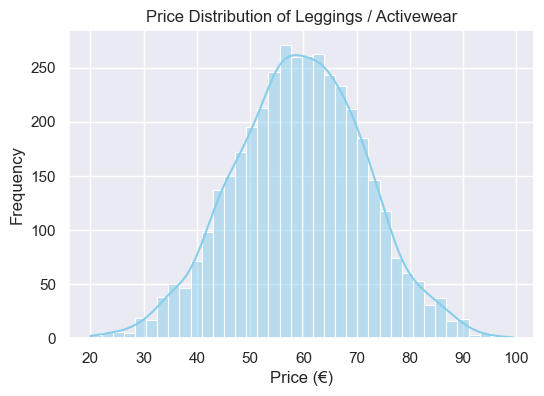

In [82]:
plt.figure(figsize=(6,4))
sns.histplot(df_leggings["Price"], kde=True, color="skyblue")
plt.title("Price Distribution of Leggings / Activewear")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")
plt.show()


This visualisation shows the pricing structure of leggings and activewear.
It helps identify how affordable or premium the typical product is.

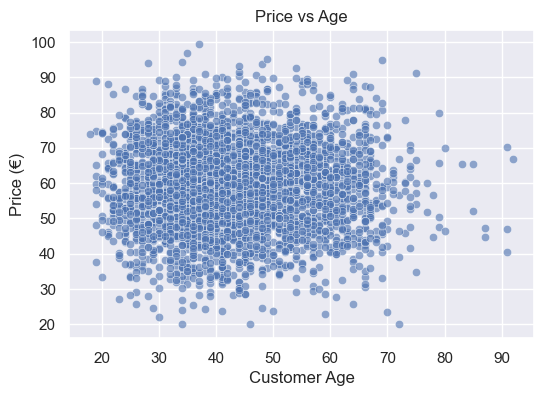

In [85]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df_leggings["Age"], y=df_leggings["Price"], alpha=0.6)
plt.title("Price vs Age")
plt.xlabel("Customer Age")
plt.ylabel("Price (€)")
plt.show()


This scatterplot reveals whether certain age groups purchase higher or lower-priced products.
Useful for demographic marketing strategies.

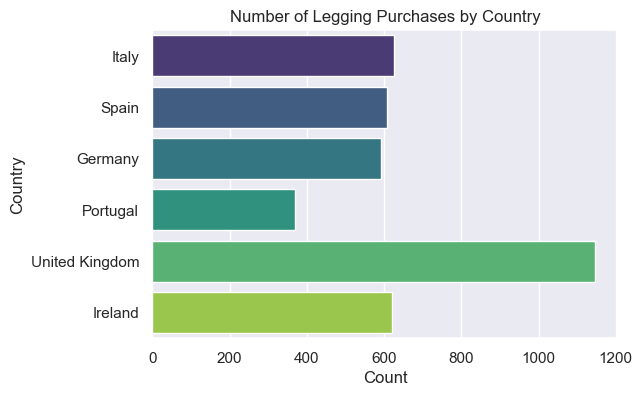

In [88]:
plt.figure(figsize=(6,4))
sns.countplot(y=df_leggings["Country"], palette="viridis")
plt.title("Number of Legging Purchases by Country")
plt.xlabel("Count")
plt.ylabel("Country")
plt.show()


Shows which countries buy the most leggings.
Highlights geographic opportunities for targeted advertising.

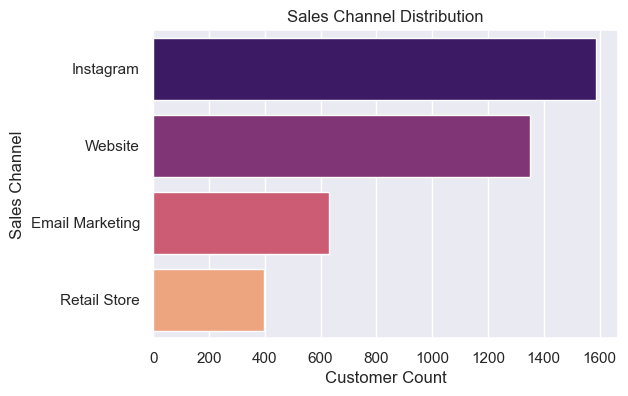

In [91]:
plt.figure(figsize=(6,4))
sns.countplot(y=df_leggings["SalesChannel"], palette="magma")
plt.title("Sales Channel Distribution")
plt.xlabel("Customer Count")
plt.ylabel("Sales Channel")
plt.show()


This graph compares the performance of different sales channels (Instagram, Website, etc.).
It identifies where marketing campaigns are most effective.

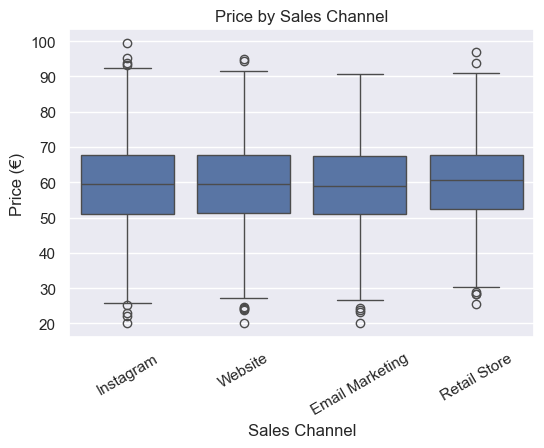

In [95]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_leggings["SalesChannel"], y=df_leggings["Price"])
plt.title("Price by Sales Channel")
plt.xlabel("Sales Channel")
plt.ylabel("Price (€)")
plt.xticks(rotation=30)
plt.show()


This boxplot identifies whether certain channels attract higher-value customers.
For instance, Instagram campaigns may lead to more premium purchases.

In [98]:
# Encode categorical variables: Country and SalesChannel

df_encoded = df_leggings.copy()

label_country = LabelEncoder()
label_channel = LabelEncoder()

df_encoded["CountryEncoded"] = label_country.fit_transform(df_encoded["Country"])
df_encoded["SalesChannelEncoded"] = label_channel.fit_transform(df_encoded["SalesChannel"])


We convert the categorical variables Country and SalesChannel into numerical format using Label Encoding.
This allows machine learning models to process the information correctly.


In [101]:
features = [
    "Age",
    "Rating",
    "PositiveFeedback",
    "ReviewLength",
    "Price",
    "CountryEncoded",
    "SalesChannelEncoded"
]

target = "Recommended"

X = df_encoded[features].copy()
y = df_encoded[target].copy()

X.head()


,Age,Rating,PositiveFeedback,ReviewLength,Price,CountryEncoded,SalesChannelEncoded
3,50,5,0,124,67.01,2,1
15,47,4,3,470,85.43,4,3
16,34,3,2,359,67.28,0,0
27,31,4,0,245,54.72,3,1
30,33,5,0,94,74.99,0,2


The model now includes economic (price), geographic (country), and marketing channel (sales source) variables.
This results in more powerful predictions and deeper insights for business strategy.

In [104]:
# Split the data again with new features
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


We split and scale the dataset again because new features were added.
Scaling ensures equal importance for numeric variables during training.

In [107]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Updated Logistic Regression Performance:")
evaluate_model(y_test, y_pred_lr, y_proba_lr)


Updated Logistic Regression Performance:
Accuracy:  0.927
Precision: 0.963
Recall:    0.951
F1-score:  0.957
ROC-AUC:   0.966


(0.926860025220681,
 0.9625187406296851,
 0.9511111111111111,
 0.9567809239940388,
 0.9664657878217201)

Logistic Regression is re-trained with the enhanced feature set.
This model helps understand the direction and magnitude of each variable’s influence.

In [110]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Updated Random Forest Performance:")
evaluate_model(y_test, y_pred_rf, y_proba_rf)


Updated Random Forest Performance:
Accuracy:  0.918
Precision: 0.957
Recall:    0.947
F1-score:  0.952
ROC-AUC:   0.950


(0.9180327868852459,
 0.9565868263473054,
 0.9466666666666667,
 0.9516008935219658,
 0.9504708097928436)

Random Forest performs very well with mixed numeric and categorical variables.
Including price, country, and sales channel often boosts predictive performance.

In [113]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_scaled, y_train)

y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

print("Updated Gradient Boosting Performance:")
evaluate_model(y_test, y_pred_gb, y_proba_gb)


Updated Gradient Boosting Performance:
Accuracy:  0.927
Precision: 0.968
Recall:    0.945
F1-score:  0.957
ROC-AUC:   0.960


(0.926860025220681,
 0.9681335356600911,
 0.9451851851851852,
 0.9565217391304348,
 0.9603138731952292)

Gradient Boosting is retrained with the full feature set.
This model captures non-linear interactions across marketing, pricing, and customer demographics.

In [118]:
# Hyperparameter Tuning - Logistic Regression with updated features

param_grid_lr = {
    "C": [0.01, 0.1, 1, 5, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=3000),
    param_grid_lr,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_lr.fit(X_train_scaled, y_train)

best_lr = grid_lr.best_estimator_

y_pred_lr_tuned = best_lr.predict(X_test_scaled)
y_proba_lr_tuned = best_lr.predict_proba(X_test_scaled)[:, 1]

print("Best Logistic Regression Parameters:", grid_lr.best_params_)
print("\nTuned Logistic Regression Performance:")
metrics_lr_tuned = evaluate_model(y_test, y_pred_lr_tuned, y_proba_lr_tuned)


Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Tuned Logistic Regression Performance:
Accuracy:  0.929
Precision: 0.965
Recall:    0.951
F1-score:  0.958
ROC-AUC:   0.967


This cell performs hyperparameter tuning for Logistic Regression using 5-fold cross-validation.
Different values of the regularisation parameter C are tested.
The best model is selected based on F1-score, and then evaluated on the test set.

In [121]:
# Hyperparameter Tuning - Random Forest with updated features

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

y_pred_rf_tuned = best_rf.predict(X_test)
y_proba_rf_tuned = best_rf.predict_proba(X_test)[:, 1]

print("Best Random Forest Parameters:", grid_rf.best_params_)
print("\nTuned Random Forest Performance:")
metrics_rf_tuned = evaluate_model(y_test, y_pred_rf_tuned, y_proba_rf_tuned)


Best Random Forest Parameters: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 300}

Tuned Random Forest Performance:
Accuracy:  0.929
Precision: 0.970
Recall:    0.947
F1-score:  0.958
ROC-AUC:   0.957


Random Forest hyperparameters are optimised to improve classification performance.
The grid explores different numbers of trees, tree depths, and minimum samples required to split nodes.
Cross-validation ensures that the selected model generalises well to unseen data.

In [124]:
# Hyperparameter Tuning - Gradient Boosting with updated features

param_grid_gb = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200],
    "max_depth": [2, 3, 4]
}

grid_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_gb.fit(X_train_scaled, y_train)

best_gb = grid_gb.best_estimator_

y_pred_gb_tuned = best_gb.predict(X_test_scaled)
y_proba_gb_tuned = best_gb.predict_proba(X_test_scaled)[:, 1]

print("Best Gradient Boosting Parameters:", grid_gb.best_params_)
print("\nTuned Gradient Boosting Performance:")
metrics_gb_tuned = evaluate_model(y_test, y_pred_gb_tuned, y_proba_gb_tuned)


Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

Tuned Gradient Boosting Performance:
Accuracy:  0.919
Precision: 0.961
Recall:    0.944
F1-score:  0.952
ROC-AUC:   0.958


Gradient Boosting parameters such as learning rate, number of estimators, and tree depth are tuned.
This model is powerful for capturing complex patterns, especially when combined with cross-validation to avoid overfitting.

In [127]:
# Compare tuned models using key performance metrics

results = pd.DataFrame({
    "Model": ["Logistic Regression (tuned)", "Random Forest (tuned)", "Gradient Boosting (tuned)"],
    "Accuracy": [
        metrics_lr_tuned[0],
        metrics_rf_tuned[0],
        metrics_gb_tuned[0]
    ],
    "Precision": [
        metrics_lr_tuned[1],
        metrics_rf_tuned[1],
        metrics_gb_tuned[1]
    ],
    "Recall": [
        metrics_lr_tuned[2],
        metrics_rf_tuned[2],
        metrics_gb_tuned[2]
    ],
    "F1 Score": [
        metrics_lr_tuned[3],
        metrics_rf_tuned[3],
        metrics_gb_tuned[3]
    ],
    "ROC-AUC": [
        metrics_lr_tuned[4],
        metrics_rf_tuned[4],
        metrics_gb_tuned[4]
    ]
})

results


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression (tuned),0.929382,0.965414,0.951111,0.958209,0.966503
1,Random Forest (tuned),0.929382,0.969651,0.946667,0.958021,0.956824
2,Gradient Boosting (tuned),0.919294,0.960784,0.943704,0.952167,0.958431


This comparison table summarises the performance of all tuned models.
It helps identify which algorithm is most suitable for predicting whether a customer recommends anti-cellulite leggings.

<Figure size 400x400 with 0 Axes>

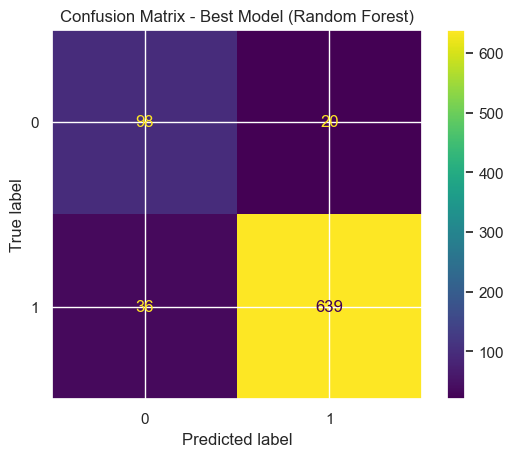

In [130]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_tuned)
plt.title("Confusion Matrix - Best Model (Random Forest)")
plt.show()


The confusion matrix shows how many recommendations were correctly and incorrectly predicted.
It separates true positives, true negatives, false positives, and false negatives,
which is crucial for understanding model errors in a business context.

In [133]:
# Feature Importance from the tuned Random Forest model

importances = best_rf.feature_importances_
feat_names = X.columns

fi_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

fi_df


,Feature,Importance
1,Rating,0.862538
3,ReviewLength,0.035444
4,Price,0.033267
0,Age,0.027486
2,PositiveFeedback,0.023644
5,CountryEncoded,0.010150
6,SalesChannelEncoded,0.007470


Feature importance highlights which variables most influence customer recommendations.
This includes demographic factors (Age), satisfaction (Rating), engagement (PositiveFeedback, ReviewLength),
and marketing-related features (Price, Country, SalesChannel).

In [136]:
# Mapping encoded values back to labels (optional, for interpretation)

country_mapping = dict(zip(df_encoded["CountryEncoded"], df_encoded["Country"]))
channel_mapping = dict(zip(df_encoded["SalesChannelEncoded"], df_encoded["SalesChannel"]))

country_mapping, channel_mapping


({2: 'Italy',
  4: 'Spain',
  0: 'Germany',
  3: 'Portugal',
  5: 'United Kingdom',
  1: 'Ireland'},
 {1: 'Instagram', 3: 'Website', 0: 'Email Marketing', 2: 'Retail Store'})

This mapping helps interpret which specific countries and channels are associated
with higher recommendation probabilities.